In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [2]:
#import libs to resize and read files
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from pathlib import Path
import gc

In [4]:
#######################################
# List all files in the folder
#######################################
files = list(map(str, filter(lambda file: file.is_file(), Path("C:/temp/AR_out").rglob('*'))))

In [5]:
#######################################
#declare arrays
#######################################
image_resized_list = []
file_names_list = []


#######################################
# resize all files and save in arrays
#######################################
for file in files:
    # read image
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)

    # Set Scale
    scale_percent = 10 
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dimension = (width, height)

    # resize image
    resized = cv2.resize(img, dimension, interpolation = cv2.INTER_AREA)

    #save image resized and file name in arrays
    image_resized_list.append(resized)
    file_names_list.append(file.split('\\')[-1].split('.')[0])

In [6]:
##clear memory
gc.collect()

40

In [7]:
# Convert the list to a numpy array
image_resized_array = np.array(image_resized_list)

# Get the number of images, dimensions and channels of each image
num_images, height, width, num_channels = image_resized_array.shape

# Reshape the array into a 2D array where each row is a vectorized image
data_2d = image_resized_array.reshape(num_images, -1)  # -1 is a placeholder that tells numpy to compute the size of this dimension

In [8]:
mean_vector = np.mean(data_2d, axis=0)

In [9]:
# Center the data by subtracting the mean
centered_data = data_2d - mean_vector

In [10]:
covariance_matrix = np.dot(centered_data.T, centered_data) / (num_images - 1)

In [11]:
covariance_matrix = np.cov(data_2d, rowvar=False)

import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for better visualization

# Display a heatmap of the covariance matrix
plt.figure(figsize=(10, 10))
sns.heatmap(covariance_matrix, cmap='coolwarm', fmt='.2f')
plt.show()

In [12]:
##clear memory
gc.collect()

120

In [13]:
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

In [14]:
# Get the indices that would sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]

# Sort the eigenvalues and eigenvectors
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]


In [15]:
total_variance = np.sum(sorted_eigenvalues)

In [16]:
cumulative_variance = np.cumsum(sorted_eigenvalues)

In [17]:
num_eigenvectors_to_retain = np.argmax(cumulative_variance / total_variance >= 0.99) + 1
print (num_eigenvectors_to_retain)
#num_eigenvectors_to_retain = 500

748


In [18]:
# Select the top eigenvectors to retain 99% of the variance
top_eigenvectors = sorted_eigenvectors[:, :num_eigenvectors_to_retain]


# Project the centered data onto the selected eigenvectors
projected_data = np.dot(centered_data, top_eigenvectors)

In [19]:
# Project the centered data onto the selected eigenvectors
projected_data = np.dot(centered_data, top_eigenvectors)

In [22]:
##############################################################################
#Making a test with a orignal, resized and projected image
##############################################################################
index = 2034  # Index of the image you want to select
source_image = cv2.imread(files[index], cv2.IMREAD_UNCHANGED) 
resized_image = image_resized_array[index]
original_image = image_resized_array[index]

In [23]:
projected_representation = projected_data[index]
reconstructed_image_data = np.dot(projected_representation, top_eigenvectors.T)

In [24]:
reconstructed_image = reconstructed_image_data.reshape(height, width, num_channels)
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)


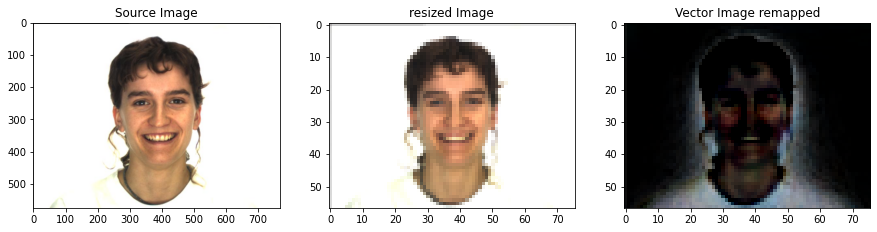

In [25]:
plt.figure(figsize=(15, 5))  # Adjust the figure size to accommodate three images

# Display source image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
plt.title('Source Image')

# Display original image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
#axs[1].imshow(resized_image)
plt.title('resized Image')

# Display reconstructed image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
plt.title('Vector Image remapped')

plt.show()

##### Merge projected_data with labels

In [26]:
import scr_deep_learning_cnn_keras_py as keras_ml
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Splitting each string by hyphen and storing the results in a new list
file_names_list = [name.split('-') for name in file_names_list]

# Creating a DataFrame from the list of split parts
file_names_list = pd.DataFrame(file_names_list, columns=['gender', 'seq', 'type'])

In [28]:
file_names_list

     gender  seq type
0         m  001    1
1         m  001   10
2         m  001   11
3         m  001   12
4         m  001   13
...     ...  ...  ...
3310      w  060    5
3311      w  060    6
3312      w  060    7
3313      w  060    8
3314      w  060    9

[3315 rows x 3 columns]


In [29]:
#Replace genre man and woman to 0 and 1
file_names_list['gender'] = file_names_list['gender'].replace('m', 0)
file_names_list['gender'] = file_names_list['gender'].replace('w', 1)

In [30]:
#Replace from string to int
file_names_list['gender'] = file_names_list['gender'].astype(int)
file_names_list['seq'] = file_names_list['seq'].astype(int)
file_names_list['type'] = file_names_list['type'].astype(int)

In [32]:
projected_data = pd.DataFrame(projected_data)


In [33]:
##clear memory
gc.collect()

7891

In [35]:
print(projected_data.shape)
print(file_names_list.shape)

(3315, 748)
(3315, 3)


In [36]:
projected_data = pd.concat([projected_data, file_names_list], axis=1)


In [37]:
projected_data.shape

(3315, 751)

In [38]:
projected_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,741,742,743,744,745,746,747,gender,seq,type
0,-3466.350784,226.509663,936.771975,52.920053,1380.270466,-758.574927,-64.936104,-320.890935,883.787151,-98.415013,...,-11.003112,6.679797,49.653419,15.719466,-11.551719,-47.818212,19.183949,0,1,1
1,-4498.098330,1478.871276,1121.669823,1180.024966,228.843861,-241.947130,899.401680,-614.588305,1168.197954,-1194.726338,...,24.585780,19.695312,-46.167904,-19.337052,20.109861,-17.026091,-9.866462,0,1,10
2,2446.641785,-1090.686057,2110.156411,2691.990784,1498.185674,-1833.459016,-463.747920,-421.612801,521.367748,147.631379,...,-64.397281,6.164419,10.203567,-34.713198,40.360524,16.799634,-44.745134,0,1,11
3,937.079475,-712.195333,1460.601550,2573.730049,955.873127,-2351.050197,-1840.811938,-51.833456,-46.428615,131.581298,...,-26.691812,-1.949141,-4.753359,-44.878843,-4.031567,38.683140,4.047155,0,1,12
4,1092.026210,-325.188885,1992.035309,2999.624469,247.914686,-2754.474634,944.541364,-170.790416,618.299259,883.335012,...,18.359045,24.333879,28.576791,-58.028658,28.914232,57.194495,-16.985502,0,1,13
5,-3625.157897,-85.238703,2716.102767,605.645940,731.964238,-826.754462,-141.564135,-441.409498,27.043411,-1297.908953,...,-28.500235,13.733569,-1.854852,-2.413203,34.012622,-26.485873,1.282710,0,1,14
6,-3476.442250,252.882949,2902.038823,1483.056918,791.303405,-815.888890,-179.037443,-1189.959789,-710.541761,-1637.680251,...,9.472624,31.472582,26.931308,20.864491,9.463491,4.604823,-11.061825,0,1,15
7,-3341.068783,205.367251,3037.976183,1094.675152,711.497411,-576.425967,-113.592372,-872.486312,-441.134010,-1286.637722,...,8.052155,14.055473,-1.164563,20.646619,6.265956,-18.781832,-2.859147,0,1,16
8,-3280.090374,37.106941,2835.515910,1182.900680,942.768786,-942.082604,-206.022325,-817.549586,-600.577123,-1462.308151,...,9.987325,10.435697,19.948346,1.492998,49.901248,-20.898563,0.797612,0,1,17
9,-4640.030316,562.688099,2132.209084,1515.786361,-294.685566,-907.533030,-1536.439397,-1143.986567,-770.757901,-1299.491999,...,11.212186,-0.219100,52.271037,-16.025587,9.221183,32.022629,30.489162,0,1,18


In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(projected_data.iloc[:, :748].values, projected_data.iloc[:, 749].values, test_size=0.3, random_state=0)

In [ ]:
# DEBUG. Plot some of the images
plt.figure(figsize=(18, 9))

num_rows = 4
num_cols = 5

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    ax.title.set_text(y_train[i,0])
    plt.axis("off")

# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = keras_ml.to_categorical(y_train)
y_test  = keras_ml.to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

# Create the model.
model = keras_ml.cnn_model()
model.summary()

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
             )

history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_split=.3,
                   )


# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

keras_ml.plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

keras_ml.plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [ ]:
# Load the dataset (CIFAR-10)
(X_train, y_train), (X_test, y_test) = keras_ml.cifar10.load_data()

print('Learning set:')
print('X: ', end='')
print(X_train.shape)
print('y: ', end='')
print(y_train.shape)

print('Test set:')
print('X: ', end='')
print(X_test.shape)
print('y: ', end='')
print(y_test.shape)

# DEBUG. Plot some of the images
plt.figure(figsize=(18, 9))

num_rows = 4
num_cols = 5

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    ax.title.set_text(y_train[i,0])
    plt.axis("off")

# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = keras_ml.to_categorical(y_train)
y_test  = keras_ml.to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

# Create the model.
model = keras_ml.cnn_model()
model.summary()

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
             )

history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_split=.3,
                   )


# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

keras_ml.plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

keras_ml.plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [ ]:
#Build a Gender model

In [ ]:
#Build a Glasses

In [ ]:
#Build a ID model


In [ ]:
#Build a Facial expression